In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm, t, johnsonsu
import requests
from io import BytesIO, StringIO
from zipfile import ZipFile
import properscoring as ps
import seaborn as sns
import matplotlib.pyplot as plt

from copulae import GaussianCopula, StudentCopula

np.random.seed(607)

In [2]:
# Function for analyzing the factor
def analyze_factor(factor_name, fold1, fold2):
    # Fit models to fold1
    m1 = fold1[factor_name]
    params_normal = norm.fit(m1)
    params_t = t.fit(m1)
    params_johnsonsu = johnsonsu.fit(m1)

    # Select among the three models using CRPS on fold2
    m2 = fold2[factor_name]

    crps_normal = np.mean(ps.crps_ensemble(m2, norm.rvs(*params_normal, size=len(m2))))
    crps_t = np.mean(ps.crps_ensemble(m2, t.rvs(*params_t, size=len(m2))))
    crps_johnsonsu = np.mean(ps.crps_ensemble(m2, johnsonsu.rvs(*params_johnsonsu, size=len(m2))))

    # Report the best model and the fitted parameters
    best_model = min([(crps_normal, 'Normal', params_normal),
                      (crps_t, 'Student t', params_t),
                      (crps_johnsonsu, 'Johnson Su', params_johnsonsu)], key=lambda x: x[0])

    print(f"Best model for {factor_name}: {best_model[1]}")
    print(f"Fitted parameters for {factor_name}: {best_model[2]}")

    # Compute PIT values for the chosen model on fold 2
    if best_model[1] == 'Normal':
        cdf_values = norm.cdf(m2, *params_normal)
    elif best_model[1] == 'Student t':
        cdf_values = t.cdf(m2, *params_t)
    elif best_model[1] == 'Johnson Su':
        cdf_values = johnsonsu.cdf(m2, *params_johnsonsu)

    # Plot PIT values
    plt.figure(figsize=(4, 4))

    sns.histplot(cdf_values, bins=20, cumulative=True, alpha=0.75)
    sns.histplot(cdf_values, bins=20, color='red', alpha=0.75)
    plt.title(f'PDF and CDF for PIT Values of the Chosen Model ({factor_name})')

    plt.show()

    return best_model
    
def compute_pit_fold1(factor_name, fold1, best_model):
    m1 = fold1[factor_name]

    if best_model[1] == 'Normal':
        cdf_values = norm.cdf(m1, *best_model[2])
    elif best_model[1] == 'Student t':
        cdf_values = t.cdf(m1, *best_model[2])
    elif best_model[1] == 'Johnson Su':
        cdf_values = johnsonsu.cdf(m1, *best_model[2])

    return cdf_values
   

Best model for m: Student t
Fitted parameters for m: (3.4521298217216843, 0.008635493468786549, 0.03801716366296638)


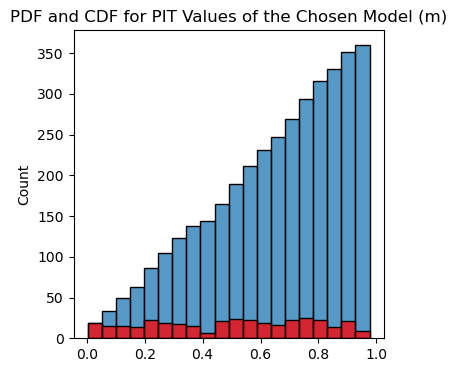

Best model for hml: Student t
Fitted parameters for hml: (2.576925003219193, 0.0020010206911395003, 0.019883798626802035)


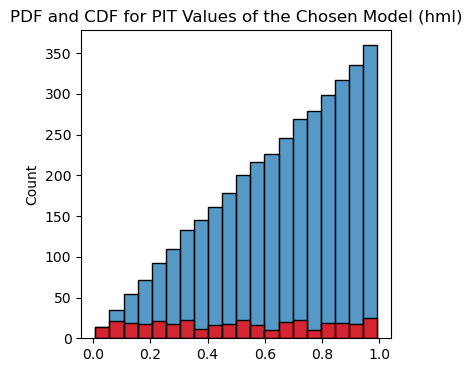

Best model for smb: Johnson Su
Fitted parameters for smb: (-0.20427038139388667, 1.4030329290662709, -0.0033247496754230414, 0.032036357928795)


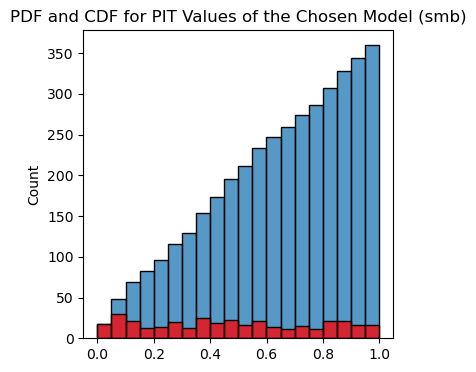

In [3]:
# Step 1: Download data from Ken French's website
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
response = requests.get(url)

import warnings
warnings.filterwarnings("ignore")

with ZipFile(BytesIO(response.content)) as zfile:
    with zfile.open('F-F_Research_Data_Factors.CSV') as file:
        csv_data = pd.read_csv(file, skiprows=3, index_col=0)

# Convert the data to numeric format and drop rows with missing values
csv_data = csv_data.apply(pd.to_numeric, errors='coerce').dropna()

# Keep only the monthly observations
csv_data = csv_data[csv_data.index.map(lambda x: x.isdigit() and len(x) == 6)]

# Step 2: Compute m
csv_data['m'] = (csv_data['Mkt-RF'] / 100) / (1 + csv_data['RF'] / 100)
csv_data['Mkt'] = csv_data['Mkt-RF'] + csv_data['RF']
csv_data['hml'] = (csv_data['HML'] / 100) / (1 + csv_data['RF'] / 100)
csv_data['smb'] = (csv_data['SMB'] / 100) / (1 + csv_data['RF'] / 100)

# Step 3: Split data into folds
fold1 = csv_data.loc['192607':'198312']
fold2 = csv_data.loc['198301':'201212']
fold3 = csv_data.loc['201301':'201812']
fold4 = csv_data.loc['201901':]
    
# Step 4, 5, 6, 7: Analyze the factors, compute PIT values for fold1, and plot scatter plot
factors = ['m', 'hml', 'smb']
pit_values = {}
for factor in factors:
    best_model = analyze_factor(factor, fold1, fold2)
    pit_values[factor] = compute_pit_fold1(factor, fold1, best_model)
    

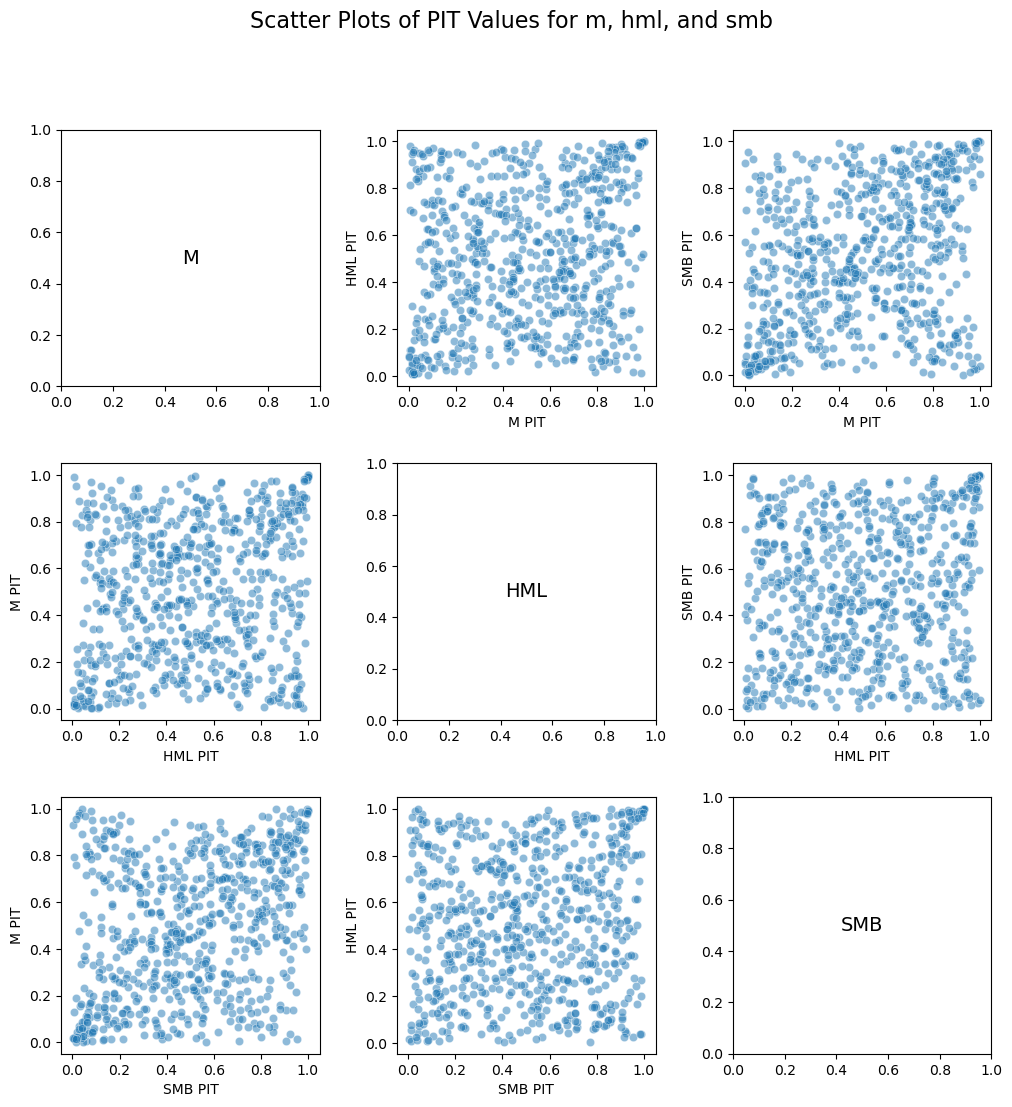

In [4]:
# Create a 3x3 grid of scatter plots for all combinations of the factors' PIT values
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, row_factor in enumerate(factors):
    for j, col_factor in enumerate(factors):
        if i == j:
            axes[i, j].text(0.5, 0.5, f"{row_factor.upper()}", fontsize=14, ha="center", va="center")
        else:
            sns.scatterplot(x=pit_values[row_factor], y=pit_values[col_factor], alpha=0.5, ax=axes[i, j])
            axes[i, j].set_xlabel(f"{row_factor.upper()} PIT")
            axes[i, j].set_ylabel(f"{col_factor.upper()} PIT")

plt.suptitle("Scatter Plots of PIT Values for m, hml, and smb", fontsize=16)
plt.show()    


In [5]:
# Combine the PIT values into a DataFrame
pit_df = pd.DataFrame(pit_values)

In [6]:
# Fit the  Gaussian Copula
from copulae import GaussianCopula

copula_gaussian = GaussianCopula(dim=3)
copula_gaussian.fit(pit_df)

In [7]:
sampled = copula_gaussian.random(len(fold1))
sampled_df = pd.DataFrame(sampled, columns=pit_df.columns)

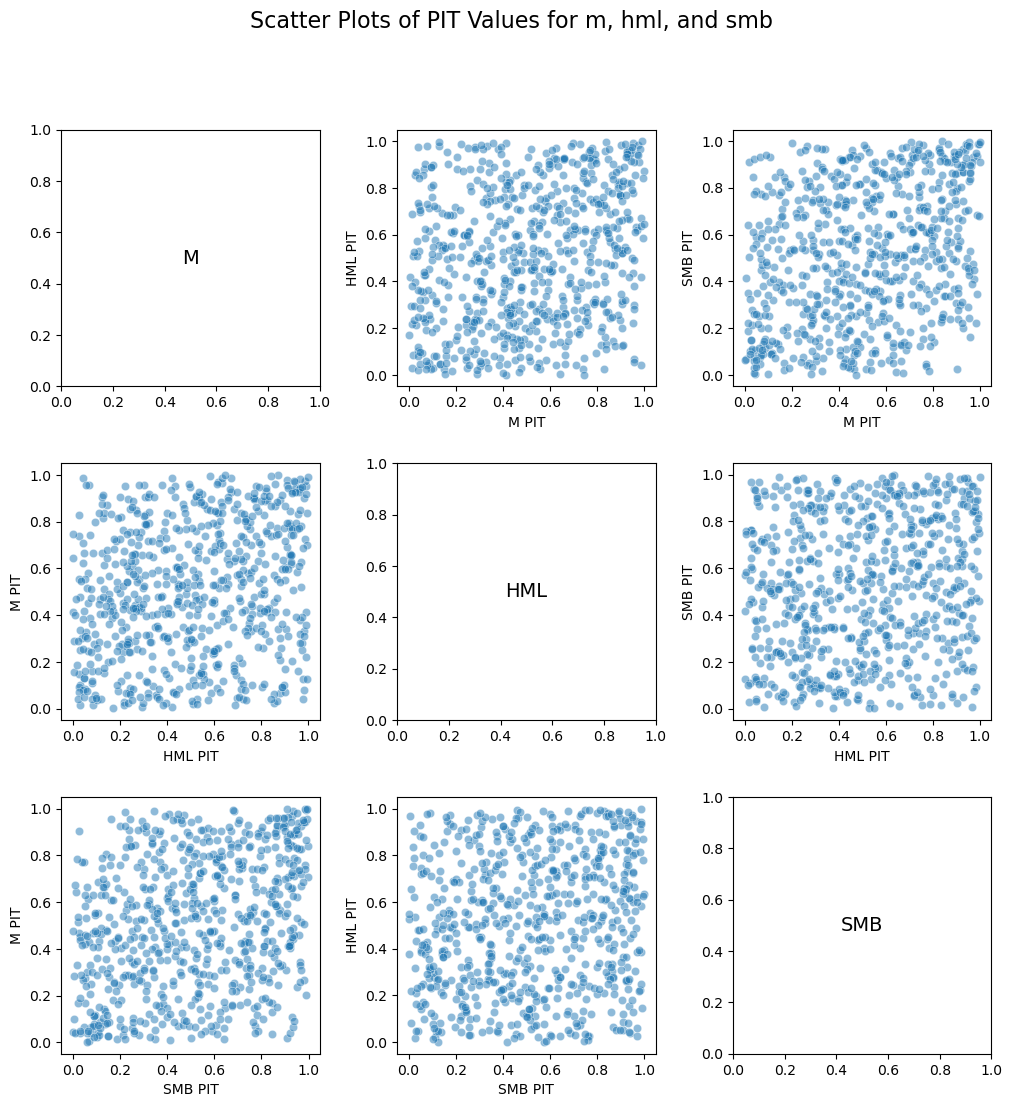

In [8]:
# Create a 3x3 grid of scatter plots for all combinations of the simulated' PIT values
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, row_factor in enumerate(factors):
    for j, col_factor in enumerate(factors):
        if i == j:
            axes[i, j].text(0.5, 0.5, f"{row_factor.upper()}", fontsize=14, ha="center", va="center")
        else:
            sns.scatterplot(x=sampled_df[row_factor], y=sampled_df[col_factor], alpha=0.5, ax=axes[i, j])
            axes[i, j].set_xlabel(f"{row_factor.upper()} PIT")
            axes[i, j].set_ylabel(f"{col_factor.upper()} PIT")

plt.suptitle("Scatter Plots of PIT Values for m, hml, and smb", fontsize=16)
plt.show()  
    

In [9]:
# Fit the  Student t Copula
copula_Student = StudentCopula(dim=3)
copula_Student.fit(pit_df)

sampled_Student = copula_Student.random(len(fold1))
sampled_df_Student = pd.DataFrame(sampled_Student, columns=pit_df.columns)

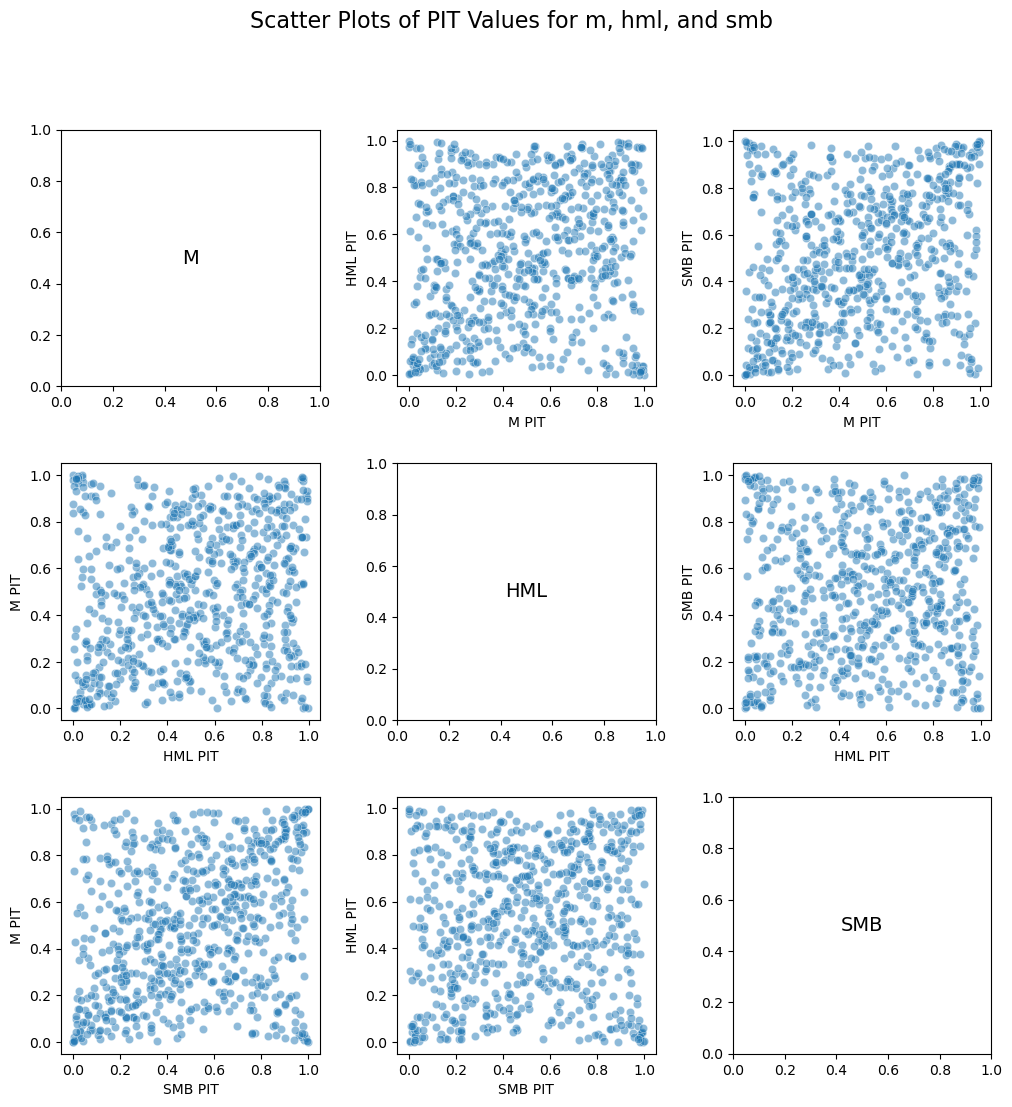

In [10]:
# Create a 3x3 grid of scatter plots for all combinations of the simulated' PIT values
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, row_factor in enumerate(factors):
    for j, col_factor in enumerate(factors):
        if i == j:
            axes[i, j].text(0.5, 0.5, f"{row_factor.upper()}", fontsize=14, ha="center", va="center")
        else:
            sns.scatterplot(x=sampled_df_Student[row_factor], y=sampled_df_Student[col_factor], alpha=0.5, ax=axes[i, j])
            axes[i, j].set_xlabel(f"{row_factor.upper()} PIT")
            axes[i, j].set_ylabel(f"{col_factor.upper()} PIT")

plt.suptitle("Scatter Plots of PIT Values for m, hml, and smb", fontsize=16)
plt.show() 